In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
import torch
from uncertaintylearning.utils import (FixedKernelDensityEstimator, CVKernelDensityEstimator, MAFMOGDensityEstimator,
                                       create_network, create_optimizer, create_multiplicative_scheduler,
                                       MADEMOGDensityEstimator)
from uncertaintylearning.models import EpistemicPredictor, MCDropout
from torch.utils.data import DataLoader, TensorDataset


In [518]:
def oracle(x, noise=0.1):
    # returns sin(2pi x) + epsilon with epsilon ~ N(0, 0.1)
    with torch.no_grad():
        m = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1]))
        m = m.sample((x.size(0),))
        return (x ** 2).sum(axis=1).unsqueeze(1) + noise * m

def generate_data(n=128):
    # generate data from U([0, 1/2] union U([1/2 + sep, 1 + sep]))
    # sep needs to be < 1.5
    with torch.no_grad():
        m = torch.distributions.MultivariateNormal(torch.tensor([-1.0, 1.0]), .05 * torch.eye(2))
        x = m.sample(torch.Size((n,)))
        m = torch.distributions.MultivariateNormal(torch.tensor([1.0, -1.0]), .05 * torch.eye(2))
        x = torch.cat((x, m.sample(torch.Size((n,)))))
        m = torch.distributions.MultivariateNormal(torch.tensor([-1.0, -1.0]), .05 * torch.eye(2))
        x_test = m.sample(torch.Size((n,)))
        m = torch.distributions.MultivariateNormal(torch.tensor([1.0, 1.0]), .05 * torch.eye(2))
        ood_x = m.sample(torch.Size((n,)))
        y = oracle(x)
        y2 = oracle(x)
        # y2 = y
        ood_y = oracle(ood_x)
        y_test_true = oracle(x_test, noise=0)
        return x, y, y2, x_test, y_test_true, ood_x, ood_y

x, y, y2, x_test, y_test, ood_x, ood_y = generate_data()


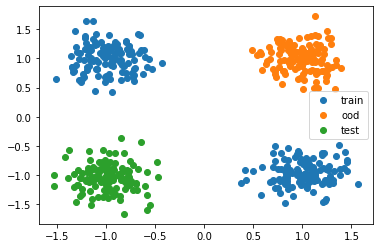

In [519]:
plt.scatter(x[:, 0], x[:, 1], label='train')
plt.scatter(ood_x[:, 0], ood_x[:, 1], label='ood')
plt.scatter(x_test[:, 0], x_test[:, 1], label='test')
plt.legend()
plt.show()

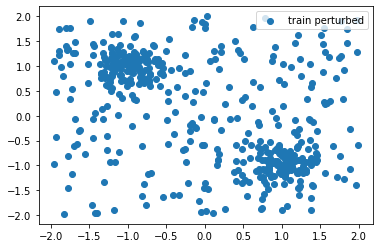

In [520]:
def perturb(x, bounds=(-2, 2)):

    xx = (bounds[1] - bounds[0]) * torch.rand_like(x) + bounds[0]
    xx = torch.cat([xx, x], axis=0)
    return xx
xx = perturb(x)

plt.scatter(xx[:, 0], xx[:, 1], label='train perturbed')
plt.legend()
plt.show()

In [591]:
density_estimator = MAFMOGDensityEstimator(n_components=3, n_blocks=5, lr=1e-4, use_log_density=True, use_density_scaling=True)
# density_estimator = MADEMOGDensityEstimator(n_components=5, lr=1e-4, epochs=20, use_log_density=True)

features = 'd'
networks = {'a_predictor': create_network(2, 1, 64, 'tanh', True),
            'e_predictor': create_network(len(features) + (1 if 'x' in features else 0), 1, 64, 'relu', True, 3),
            'f_predictor': create_network(2, 1, 64, 'relu', False)
            }

optimizers = {'a_optimizer': create_optimizer(networks['a_predictor'], 1e-3),
              'e_optimizer': create_optimizer(networks['e_predictor'], 1e-4, weight_decay=1e-2),
              'f_optimizer': create_optimizer(networks['f_predictor'], 1e-3)
              }

model = EpistemicPredictor(train_X=x,
                           train_Y=y,
                           networks=networks,
                           optimizers=optimizers,
                           density_estimator=density_estimator,
                           train_Y_2=y2,
                           ood_X=ood_x,
                           ood_Y=ood_y,
                           features=features,
                           retrain=False)


In [592]:
print(x.shape)
print(perturb(x).shape)
model.pretrain_density_estimator(perturb(x))


torch.Size([256, 2])
torch.Size([512, 2])


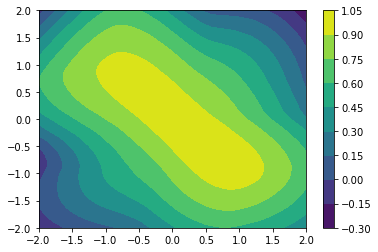

In [564]:
xmin, xmax = -2, 2
ymin, ymax = -2, 2
n = 200
xx1 = torch.linspace(xmin, xmax, n)
xx2 = torch.linspace(ymin, ymax, n)
xx, yy = torch.meshgrid(xx1, xx2)
xy = torch.stack((xx.flatten(), yy.flatten()), dim=-1).squeeze()
density = density_estimator.score_samples(xy).squeeze()
plt.contourf(xx, yy,
             density.view(n, n).data.numpy(), # if not density_estimator.use_log_density else np.exp(density.view(n, n).data.numpy()),
             levels=10,)
plt.colorbar()

In [572]:
print('train', density_estimator.score_samples(x).min(), density_estimator.score_samples(x).mean(), density_estimator.score_samples(x).max())
print('ood', density_estimator.score_samples(ood_x).min(), density_estimator.score_samples(ood_x).mean(), density_estimator.score_samples(ood_x).max())
print('test', density_estimator.score_samples(x_test).min(), density_estimator.score_samples(x_test).mean(), density_estimator.score_samples(x_test).max())

train tensor(0.6160) tensor(0.8737) tensor(0.9995)
ood tensor(0.0336) tensor(0.4201) tensor(0.6275)
test tensor(0.0899) tensor(0.3497) tensor(0.6798)


In [593]:
epochs = 30
losses_afe = {'a': [], 'e': [], 'f': []}

for i in range(epochs):
    if i % (1 if model.retrain else 5) == 0:
        print('epoch ', i)
    new_losses = model.fit()
    if np.isnan(new_losses['e']).any():
        print('nan')
        break
    for key in 'afe':
        if model.retrain:
            losses_afe[key].extend(new_losses[key])
        else:
            losses_afe[key].append(np.mean(new_losses[key]))


epoch  0
epoch  5
epoch  10
epoch  15
epoch  20
epoch  25


In [594]:
np.isnan(new_losses['e']).any()

False

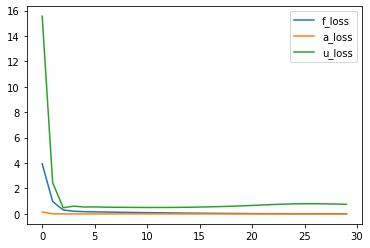

In [595]:
plt.plot(losses_afe['f'], label='f_loss')
plt.plot(losses_afe['a'], label='a_loss')
plt.plot(losses_afe['e'], label='u_loss')
plt.legend()
plt.show()

In [596]:
predictions = networks['f_predictor'](x).detach().numpy().ravel()
print('train error:', ((predictions - y.numpy().ravel()) ** 2).mean())

predictions = networks['f_predictor'](x_test).detach().numpy().ravel()
print('test error:', ((predictions - y_test.numpy().ravel()) ** 2).mean())

predictions = networks['f_predictor'](ood_x).detach().numpy().ravel()
print('ood error:', ((predictions - ood_y.numpy().ravel()) ** 2).mean())

train error: 0.012494106
test error: 1.4765329
ood error: 1.991442


In [597]:
print('train mean epis: ', model._epistemic_uncertainty(x).detach().numpy().ravel().mean())
print('ood mean epis: ', model._epistemic_uncertainty(ood_x).detach().numpy().ravel().mean())
print('test mean epis: ', model._epistemic_uncertainty(x_test).detach().numpy().ravel().mean())


train mean epis:  0.24813211
ood mean epis:  0.7964013
test mean epis:  0.7964013


In [598]:
def plot_utils(images, fig, axes):
    # Find the min and max of all colors for use in setting the color scale.
    vmin = min(image.get_array().min() for image in images)
    vmax = max(image.get_array().max() for image in images)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for im in images:
        im.set_norm(norm)

    fig.colorbar(images[-1], ax=axes, orientation='horizontal', fraction=.1)


    # Make images respond to changes in the norm of other images (e.g. via the
    # "edit axis, curves and images parameters" GUI on Qt), but be careful not to
    # recurse infinitely!
    def update(changed_image):
        for im in images:
            if (changed_image.get_cmap() != im.get_cmap()
                    or changed_image.get_clim() != im.get_clim()):
                im.set_cmap(changed_image.get_cmap())
                im.set_clim(changed_image.get_clim())


    for im in images:
        im.callbacksSM.connect('changed', update)


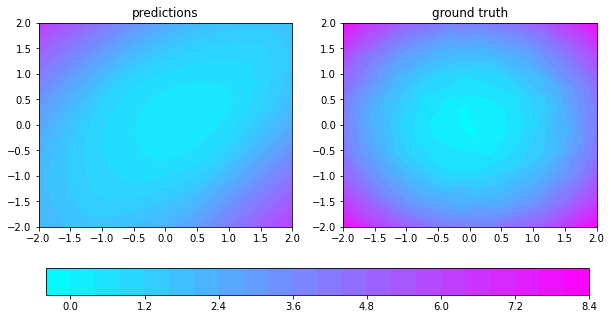

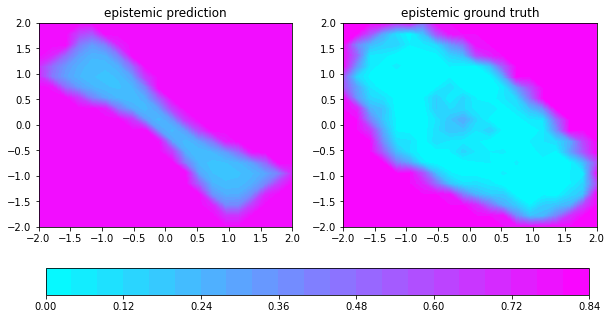

In [599]:
from matplotlib import colors 
xmin, xmax = -2, 2
ymin, ymax = -2, 2
n = 20
xx1 = torch.linspace(xmin, xmax, n)
xx2 = torch.linspace(ymin, ymax, n)
xx, yy = torch.meshgrid(xx1, xx2)
xy = torch.stack((xx.flatten(), yy.flatten()), dim=-1).squeeze()


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
images = []

cmap = plt.cm.cool

predictions = networks['f_predictor'](xy).detach().squeeze()
images.append(axes[0].contourf(xx, yy, predictions.view(n, n).data.numpy(), levels=20, cmap=cmap))
images.append(axes[1].contourf(xx, yy, oracle(xy).view(n, n).data.numpy(), levels=20, cmap=cmap))
plot_utils(images, fig, axes)
axes[0].set_title('predictions')
axes[1].set_title('ground truth')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
images = []
predicted_uncertainty = model._epistemic_uncertainty(xy).detach().squeeze()
epistemic_ground_truth = ((predictions - oracle(xy).squeeze())**2).clamp(0, .8)
images.append(axes[0].contourf(xx, yy, predicted_uncertainty.view(n, n).data.numpy(), levels=20, cmap=cmap))
images.append(axes[1].contourf(xx, yy, epistemic_ground_truth.view(n, n).data.numpy(), levels=20, cmap=cmap))

axes[0].set_title('epistemic prediction')
axes[1].set_title('epistemic ground truth')
plot_utils(images, fig, axes)
plt.show()